## Wrapper for the Common Lisp (SBCL) code
# STOCHASTIC MUSIC GENERATOR

This will run the LISP code, extract the melody, reconstruct the probability matrix, and visualize it.

It shows how the probability distributions in small samples may vary wildly from the original matrix, while larger samples tend to approach the original data according to the "law of big numbers."

## Backstage functions for the extraction:

In [65]:
import subprocess


NOTE_ORDER = ["C", "D", "E", "F", "G", "A", "B"]


def parse_note_sequence(line):
    """
    Convert the LISP output like "C G A F E" into a Python list
    """

    return line.split()


def run_lisp_script(filename, prefix="Generated Melody:"):
    """
    Runs the LISP file and extracts the generated melody following the defined prefix from the output.
    """

    result = subprocess.run(["sbcl", "--script", filename], capture_output=True, text=True)

    if result.returncode:
        raise RuntimeError(f"LISP error in '{filename}': '{result.stderr}'.")

    output = result.stdout
    print(f"Raw output from '{filename}' in SBCL:\n{output}")

    for line in output.splitlines():
        if line.startswith(prefix):
            print("Extraction successful.")
            return line[len(prefix):].strip()

    raise ValueError(f"Error: No output after '{prefix}' found.")

## Run the LISP code and show what was generated:

In [66]:
filename = "smg.lisp"

try:
    note_line = run_lisp_script(filename)
    melody = parse_note_sequence(note_line)

    print(f"\nParsed a melody with {len(melody)} elements:\n", melody)

except Exception as e:
    print(f"An error occurred while running '{filename}':", e)

Raw output from 'smg.lisp' in SBCL:
Generated Melody: C G A F A B D C E F A B C E F G C G C G C E G C G C D C E G B C 

Extraction successful.

Parsed a melody with 32 elements:
 ['C', 'G', 'A', 'F', 'A', 'B', 'D', 'C', 'E', 'F', 'A', 'B', 'C', 'E', 'F', 'G', 'C', 'G', 'C', 'G', 'C', 'E', 'G', 'C', 'G', 'C', 'D', 'C', 'E', 'G', 'B', 'C']


In [67]:
from collections import defaultdict


def reconstruct_transition_matrix(melody):
    """
    Analyzes a list of notes and
    returns a dictionary of transition counts and normalized probabilities.
    """

    counts = defaultdict(lambda: defaultdict(int))

    for current, next_note in zip(melody, melody[1:]):
        counts[current][next_note] += 1

    probabilities = {}
    for note, transitions in counts.items():
        total = sum(transitions.values())
        probabilities[note] = {number: round(count / total, 3) for number, count in transitions.items()}

    return dict(counts), probabilities


def print_statistics(counts, probabilities):
    print("STATISTICS:")

    print("   1. Transition Counts:")
    for key, value in counts.items():
        print(f"      {key} → {dict(value)}")

    print("\n   2. Reconstructed Probabilities (normalized):")
    for key, value in probabilities.items():
        print(f"      {key} → {value}")


def print_transitions_lisp_style(probabilities):
    """
    For easy comparison, this re-creates mock LISP code from the statistics.
    """

    print("\nTRANSITIONS (LISP-style):")
    print("(defparameter *reconstructed-transitions*")
    print("  '(")
    for note in NOTE_ORDER:
        if note in probabilities:
            transitions = probabilities[note]
            ordered_targets = [tone for tone in NOTE_ORDER if tone in transitions]
            value = " ".join(
                f"(\"{tone}\" . {round(transitions[tone], 1)})"
                for tone in ordered_targets
            )
            print(f"    (\"{note}\" . ({value}))")
    print("  ))")

In [68]:
counts, probs = reconstruct_transition_matrix(melody)

print_statistics(counts, probs)
print_transitions_lisp_style(probs)

STATISTICS:
   1. Transition Counts:
      C → {'G': 4, 'E': 4, 'D': 1}
      G → {'A': 1, 'C': 5, 'B': 1}
      A → {'F': 1, 'B': 2}
      F → {'A': 2, 'G': 1}
      B → {'D': 1, 'C': 2}
      D → {'C': 2}
      E → {'F': 2, 'G': 2}

   2. Reconstructed Probabilities (normalized):
      C → {'G': 0.444, 'E': 0.444, 'D': 0.111}
      G → {'A': 0.143, 'C': 0.714, 'B': 0.143}
      A → {'F': 0.333, 'B': 0.667}
      F → {'A': 0.667, 'G': 0.333}
      B → {'D': 0.333, 'C': 0.667}
      D → {'C': 1.0}
      E → {'F': 0.5, 'G': 0.5}

TRANSITIONS (LISP-style):
(defparameter *reconstructed-transitions*
  '(
    ("C" . (("D" . 0.1) ("E" . 0.4) ("G" . 0.4)))
    ("D" . (("C" . 1.0)))
    ("E" . (("F" . 0.5) ("G" . 0.5)))
    ("F" . (("G" . 0.3) ("A" . 0.7)))
    ("G" . (("C" . 0.7) ("A" . 0.1) ("B" . 0.1)))
    ("A" . (("F" . 0.3) ("B" . 0.7)))
    ("B" . (("C" . 0.7) ("D" . 0.3)))
  ))


### This (hardcoded in MD!) is the original probabilities distribution from the LISP code for comparison:

(defparameter *transitions*

  '(

    ("C" . (("D" . 0.3) ("E" . 0.3) ("G" . 0.4)))

    ("D" . (("E" . 0.4) ("F" . 0.3) ("C" . 0.3)))

    ("E" . (("F" . 0.4) ("G" . 0.3) ("D" . 0.3)))

    ("F" . (("G" . 0.5) ("A" . 0.2) ("E" . 0.3)))

    ("G" . (("A" . 0.3) ("B" . 0.3) ("C" . 0.4)))

    ("A" . (("B" . 0.4) ("C" . 0.3) ("F" . 0.3)))

    ("B" . (("C" . 0.5) ("D" . 0.5)))

    )

)


## What follows is a visual representation of the scale relations in the generated melody:

In [69]:
import matplotlib.pyplot as plt
import networkx as nx


def draw_transition_graph(probabilities):
    """
    This draws a directed graph of the transition probabilities.
    All the math is done automatically by NetworkX because I can't do that myself. :)
    It's quite a bit of boilerplate textbook code.
    """

    graph = nx.DiGraph()

    for current_note in NOTE_ORDER:                         # add nodes
        graph.add_node(current_note)

    for source, targets in probabilities.items():           # add weighted edges from source to target nodes
        for target, weight in targets.items():
            graph.add_edge(source, target, weight=weight)

    node_position = nx.circular_layout(graph)               # pick a show-off circular layout
    figure, axes = plt.subplots(figsize=(8, 8))

    nx.draw_networkx_nodes(
        graph, node_position, ax=axes,
        node_color="skyblue", node_size=800, edgecolors="black"
    )

    nx.draw_networkx_labels(
        graph, node_position, ax=axes,
        font_size=14, font_weight="bold"
    )

    edges = graph.edges(data=True)                              # mark weights by color and size
    weights = [d["weight"] * 5 for (_, _, d) in edges]
    edge_colors = [d["weight"] for (_, _, d) in edges]

    nx.draw_networkx_edges(
        graph, node_position, ax=axes,
        edge_color=edge_colors,
        width=weights,
        edge_cmap=plt.cm.viridis,
        arrows=True,
        arrowsize=20,
        connectionstyle="arc3,rad=0.15"
    )

    colorbar_mapper = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(0, 1))   # define scale layout
    colorbar_mapper.set_array([])
    figure.colorbar(
        colorbar_mapper, ax=axes, label="Transition Probability", orientation="vertical", shrink=0.8
    )

    axes.set_axis_off()
    plt.title("Reconstructed Transition Matrix", fontsize=16)
    plt.tight_layout()
    plt.show()

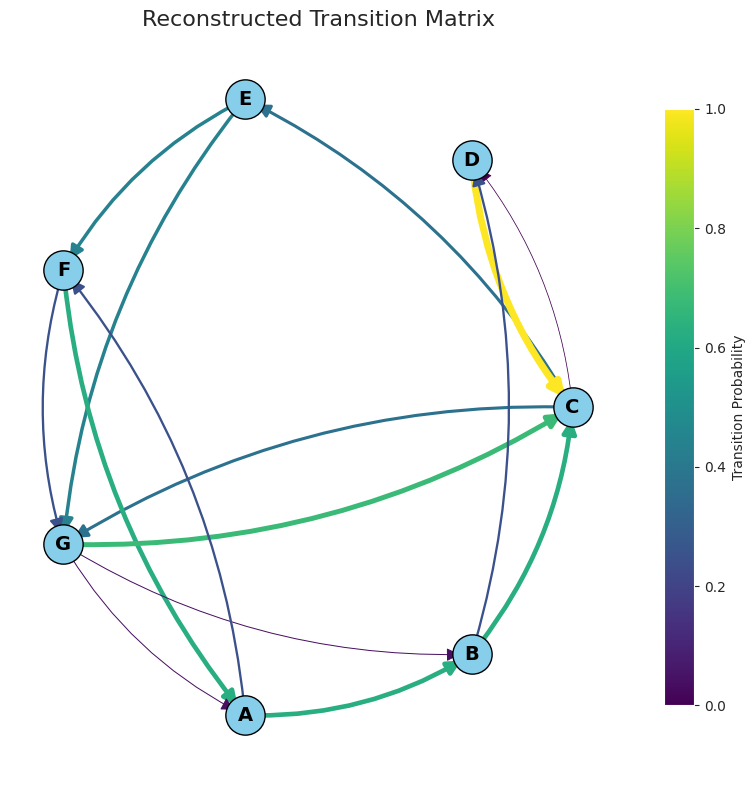

In [70]:
_, probs = reconstruct_transition_matrix(melody)
draw_transition_graph(probs)

## ... and a heatmap of deviations (actual output -> raw transition matrix data)

In [71]:
import numpy as np
import seaborn as sns


TRANSITIONS = {
    "C": [("D", 0.3), ("E", 0.3), ("G", 0.4)],
    "D": [("E", 0.4), ("F", 0.3), ("C", 0.3)],
    "E": [("F", 0.4), ("G", 0.3), ("D", 0.3)],
    "F": [("G", 0.5), ("A", 0.2), ("E", 0.3)],
    "G": [("A", 0.3), ("B", 0.3), ("C", 0.4)],
    "A": [("B", 0.4), ("C", 0.3), ("F", 0.3)],
    "B": [("C", 0.5), ("D", 0.5)],
}

def draw_deviation_heatmap(counts, expected_probs):
    matrix = np.zeros((len(NOTE_ORDER), len(NOTE_ORDER)))

    for row, source in enumerate(NOTE_ORDER):
        row_total = sum(counts.get(source, {}).values())
        if row_total == 0:
            continue

        for column, target in enumerate(NOTE_ORDER):
            observed = counts[source].get(target, 0)
            expected_prob = dict(TRANSITIONS.get(source, [])).get(target, 0)
            expected = row_total * expected_prob

            if expected > 0:
                matrix[row][column] = (observed - expected) / expected

    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix,
        xticklabels=NOTE_ORDER, yticklabels=NOTE_ORDER,
        annot=True, fmt=".2f", center=0, cmap="coolwarm"
    )
    plt.title("Deviation from Matrix")
    plt.xlabel("Next Note")
    plt.ylabel("Current Note")
    plt.tight_layout()
    plt.show()

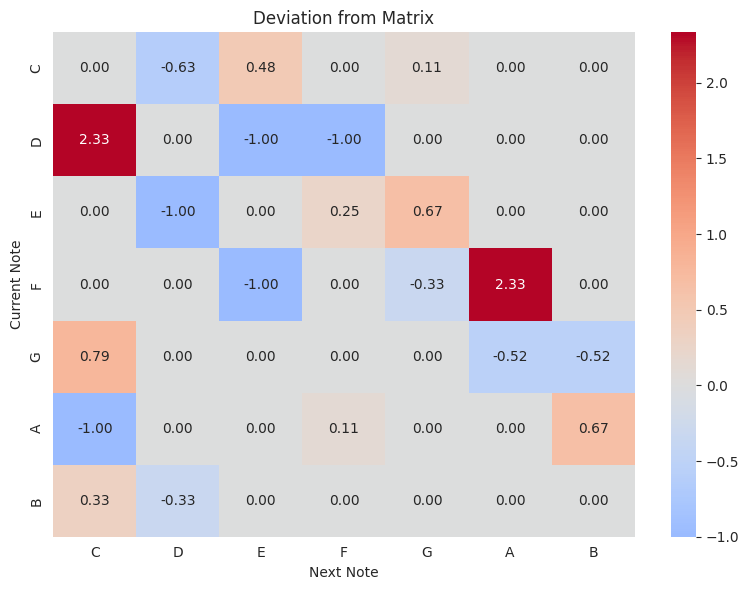

In [72]:
draw_deviation_heatmap(counts, TRANSITIONS)